In [1]:
# System
import sys
sys.path.insert(0, './analysis_scripts/')

# Math
import numpy as np
import pandas as pd
import pickle

# Plots
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 20})
fs = 20
# colors
import matplotlib.colors as mcolors


# scvi
import anndata
import scanpy as sc


# sklearn
from sklearn.metrics import silhouette_score 


from calculate_metrics import *

In [2]:
# colors
color_list = [sns.color_palette()[0],
              sns.color_palette("YlOrBr")[1],
              sns.color_palette("YlOrBr")[3],
              sns.color_palette("YlOrBr")[5]]
color_dict = {'scVI-10-NAS_SHAPE' : sns.color_palette()[0],
              'Bursty-10-NAS_SHAPE' : sns.color_palette("YlOrBr")[1],
              'Constitutive-10-NAS_SHAPE' : sns.color_palette("YlOrBr")[3],
              'Extrinsic-10-NAS_SHAPE' : sns.color_palette("YlOrBr")[5], 
}

setup_name_change = {'scVI-10-NAS_SHAPE':'scVI',
                     'Bursty-10-NAS_SHAPE': 'Bursty',
                     'Constitutive-10-NAS_SHAPE': 'Constitutive',
                     'Extrinsic-10-NAS_SHAPE': 'Extrinsic',}

In [3]:
# load in data
name = 'const_20ct_many'
index = 'test'
data_dir = '../../data/simulated_data/'

results_file = open(f'../../results/{name}_results_dict.pickle', 'rb')
results_dict = pickle.load(results_file)
results_file.close()


cell_types = results_dict.pop('Cell Type')
cluster_assignments_full = np.array([int(ct[2:]) for ct in cell_types])
train_index = results_dict.pop('train_index')
test_index = results_dict.pop('test_index')

if index == 'train':
    index_ = train_index
if index == 'test':
    index_ = test_index

simulated_params = np.load(f'../../data/simulated_data/{name}_params.npy')

# read in adata and subset to test or train data
adata_full = anndata.read_loom(data_dir+f'{name}.loom')
adata = adata_full[index_]
cluster_assignments = cluster_assignments_full[index_]


# add latent spaces to anndata object
for setup in results_dict.keys():
    adata.obsm[f'X_{setup}'] = results_dict[setup]['X_10'][index_]
    
    results_dict[setup]['norm_means'] = np.array(results_dict[setup]['norm_means'])[index_]
    results_dict[setup]['params']['mean'] = results_dict[setup]['params']['mean'][index_]
    results_dict[setup]['params']['dispersions'] = results_dict[setup]['params']['dispersions'][index_]
    results_dict[setup]['X_10'] = results_dict[setup]['X_10'][index_]
    

/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


--------


# Clustering Metrics

## Silhouette Score

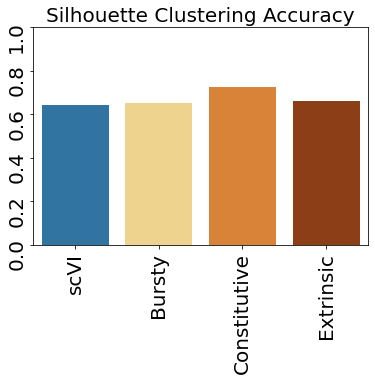

In [4]:
# n samples by n features for ss
ss_dict = {}

setups_to_compare = results_dict.keys()


for setup in setups_to_compare:
    name_ = setup.split('-')[0]
    ss_dict[name_] = [silhouette_score(adata.obsm[f'X_{setup}'], cluster_assignments)]

df_plot = pd.DataFrame(ss_dict).melt()
sns.barplot(data = df_plot,x = 'variable', y ='value',palette=color_list)
plt.title('Silhouette Clustering Accuracy',fontsize=fs)
plt.ylabel('Silhouette Value',fontsize=fs)
plt.xlabel(None)
plt.ylabel(None)
plt.xticks(fontsize = fs, rotation = 90)
plt.yticks( rotation = 90, fontsize = 20)
plt.ylim(0,1)
plt.savefig(f'../../results/{name}_figs/silhouette_{index}.png',bbox_inches='tight');

--------------

## clustering distances


In [5]:
def l2_norm(x,y):
    
    a = (x-y)**2
    l2 = np.sqrt(np.sum(a))
    
    return(l2)

def get_intra_cluster_distances(X,cluster_assignments,return_all = False):
    ''' Get distance to cluster mean for each cell.
    -----
    params:
    latent_spaces : np array, size samples x features
    
    cluster_assignments : np array or list, size samples
    
    return_all : return distance to mean of cluster for ALL cells, default FALSE
    
    (if FALSE, returns AVERAGE distance to mean for each cluster assignment)
    -----
    
    returns:
    
    av_distance_to_mean : size n_clusters
    
    cluster_var : variance in av_distance_to_mean, size n_clusters
    
    if return_all == TRUE , also returns distances_to_mean : size # samples
    '''
    
    # declare array to hold all distances
    all_distances = np.zeros(X.shape[0])
    
    # declare array to hold average distances per cluster
    cluster_assignments = np.array(cluster_assignments)
    unique_clusters = np.unique(cluster_assignments)
    
    cluster_distances = np.zeros(len(unique_clusters))
    
    # declare array to hold average variances per cluster
    cluster_variances = np.zeros(len(unique_clusters))
    
    # how many cells have we calculated distances for? 
    cells_finished = 0
    
    # now go through each cluster and calculate distance between mean of that cluster and the vector
    for i,cluster in enumerate(unique_clusters):
        
        # subset to get samples in specific cluster
        X_subset = X[cluster_assignments == cluster]
        
        # take average across all samples in the cluster of the feature values
        cluster_mean = np.mean(X_subset,axis=0)
    
        # find the distance between samples in X_subset and the cluster mean
        distances_ = np.array([l2_norm(vec,cluster_mean) for vec in X_subset])
        
        # append or add distances to distance array
        all_distances[cells_finished : (cells_finished+X_subset.shape[0])] = distances_
        cells_finished += X_subset.shape[0]
        
        # average cluster distance
        cluster_distances[i] = np.mean(distances_)
        
        # variances
        cluster_variances[i] = np.var(distances_)
    
    cluster_variances = cluster_variances[cluster_variances != 0]
    cluster_distances = cluster_distances[cluster_distances != 0]
    all_distances = all_distances[all_distances != 0]
        
    if return_all == True:
        return(cluster_distances,cluster_variances,all_distances)
    
    else:
        return(cluster_distances,cluster_variances)

In [6]:
def get_inter_cluster_distances(X,cluster_assignments):
    ''' Gets distances between all cluster means. 
    --------
    params:
    X : size samples by features
    cluster assignments: clusters of samples in X
    
    -------
    returns:
    inter_cluster_distances : matrix size cluster by cluster of distances between each cluster
    '''
        
        
    cluster_assignments = np.array(cluster_assignments)
    unique_clusters = np.unique(cluster_assignments)
    
    # array to hold mean vectors for each cluster
    cluster_means = np.ones((len(unique_clusters),X.shape[1]))
    
    # array to hold inter cluster distances
    inter_cluster_distances = np.ones((len(unique_clusters),len(unique_clusters)))
    
     # calculate each cluster mean
    for i,cluster in enumerate(unique_clusters):
        
        # subset to get samples in specific cluster
        X_subset = X[cluster_assignments == cluster]
        
        # take average across all samples in the cluster of the feature values
        cluster_mean = np.mean(X_subset,axis=0)
        cluster_means[i,:] = cluster_mean
    
    for i in range(len(unique_clusters)):
        
        for j in range(len(unique_clusters)):
            
            inter_cluster_distances[i,j] = l2_norm(cluster_means[i],cluster_means[j])
            
    return(inter_cluster_distances)

In [7]:

# create a dictionary with the latent spaces 
X_latent = {}

for setup in results_dict.keys():
    X_latent[setup.split('-')[0]] = results_dict[setup]['X_10']


    
# define dictionary of distances for each model
distance_dict = {ls : {} for ls in X_latent.keys()}
distance_dict_plot = {ls : {} for ls in X_latent.keys()}

In [8]:
for setup in X_latent.keys():
    
    cluster_distances,cluster_variances = get_intra_cluster_distances(X_latent[setup],cluster_assignments)
    inter_cluster_matrix = get_inter_cluster_distances(X_latent[setup],cluster_assignments)
    distance_dict[setup]['Intra-Cluster Distance to Mean'] = cluster_distances
    distance_dict[setup]['Intra-Cluster Variance'] = cluster_variances
    distance_dict[setup]['Inter-Cluster Distance between Means'] = inter_cluster_matrix
    distance_dict[setup]['Fano Factor'] = cluster_variances/cluster_distances 

    
    distance_dict_plot[setup]['Average Intra-Cluster Distance'] = np.mean(cluster_distances)
    distance_dict_plot[setup]['Average Intra-Cluster Variance'] = np.mean(cluster_variances)
    distance_dict_plot[setup]['Average Inter-Cluster Distance'] = np.mean(inter_cluster_matrix[inter_cluster_matrix != 0])
    distance_dict_plot[setup]['Average Fano Factor'] = np.mean(cluster_variances/cluster_distances)

In [9]:
distance_df = pd.DataFrame(distance_dict_plot).transpose

<ipython-input-10-607ce1aa1e16>:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


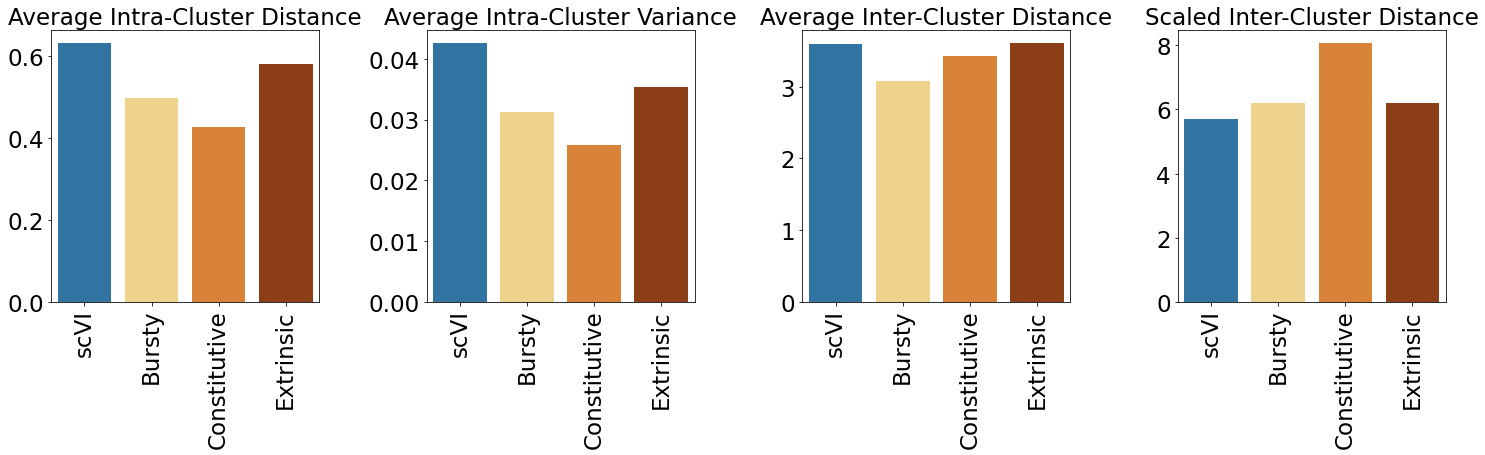

In [10]:
metrics = ['Average Intra-Cluster Distance',
           'Average Intra-Cluster Variance',
           'Average Inter-Cluster Distance']

fs = 23

fig,axes = plt.subplots(1,4,figsize = (25,5),gridspec_kw={'wspace':0.4, 'hspace':0.0})

for i,metric in enumerate(metrics):
    
    dict_plot = {}
    ax = axes[i]
    setups = list(X_latent.keys())
    metric_list = [distance_dict_plot[setup][metric] for setup in setups]
    dict_plot['setup'] = setups
    dict_plot['metric'] = metric_list
    df_plot = pd.DataFrame(dict_plot)
    sns.barplot(ax = ax, data = df_plot, x = 'setup', y ='metric',palette=color_list)
    ax.set_title(f'{metric}',fontsize = fs, wrap=True)
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    #plt.xlabel('Latent Space Method')
    ax.set_xticklabels(labels = setups, rotation = 90, fontsize = fs)
    ax.tick_params(axis='y', which='both', labelsize=fs)

ax= axes[i+1]
setups = list(X_latent.keys())
metric_list = [distance_dict_plot[setup]['Average Inter-Cluster Distance']/distance_dict_plot[setup]['Average Intra-Cluster Distance']
               for setup in setups]
dict_plot['setup'] = setups
dict_plot['metric'] = metric_list
df_plot = pd.DataFrame(dict_plot)
sns.barplot(ax = ax, data = df_plot,x = 'setup', y ='metric',palette=color_list)
ax.set_title(f'Scaled Inter-Cluster Distance',fontsize = fs)
ax.set_ylabel(f'value',fontsize=fs)
ax.set_xticklabels(labels = setups, rotation = 90, fontsize = fs)
ax.set_ylabel(None)
ax.set_xlabel(None)
ax.tick_params(axis='y', which='both', labelsize=fs)
    
plt.tight_layout()
plt.savefig(f'../../results/{name}_figs/clustering_metrics_{index}.png',bbox_inches='tight');

-------

# MSE and Nearest Neighbor Accuracy


In [11]:
metric_dict = get_metrics(name,results_dict,simulated_params,cluster_assignments,adata)

10
scVI-10-NAS_SHAPE
(2000, 4000)
Bursty-10-NAS_SHAPE
(2000, 4000)
Constitutive-10-NAS_SHAPE
(2000, 4000)
Extrinsic-10-NAS_SHAPE
(2000, 4000)


In [12]:
def get_df_plot(metric_df,metric):
  ''' Returns a dataframe in an easily plot-able format given metric_df and the metric targeted to plot. 
  '''

  plot_dict = {}
  for setup in metric_df.keys():

    setup_df = metric_df[setup]
    if metric in setup_df.keys():
      plot_dict[setup[:-13]] = setup_df[metric]
    df_plot = pd.DataFrame(plot_dict)
 
  return(df_plot)

def plot_metrics(metric_dict,metrics,fs=fs,zoom=None):
    
  fig,axes = plt.subplots(1,len(metrics),figsize= (10*len(metrics),10))

  #plt.xticks(rotation=90)
  for i,m in enumerate(metrics):
    if len(metrics) == 1:
        ax = axes
    else:
        ax = axes[i]
    plot_df = get_df_plot(metric_dict,m)
    _ = sns.violinplot(x="variable", y="value", data=plot_df.melt().dropna(),ax=ax,palette=color_list)

    #ax.set_title(f'{m}',fontsize=25)
    ax.tick_params(labelrotation=90)
    if zoom is not None:
        ax.set_ylim(0,100)
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.tick_params(axis='x', which='both', labelsize=30)
    ax.tick_params(axis='y', which='both', labelsize=fs)
    
      #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tight_layout()


In [13]:
metric_dict['scVI-10-NAS_SHAPE'].keys()

dict_keys(['MSE', 'Pearson_R', 'nearest_neighbors'])

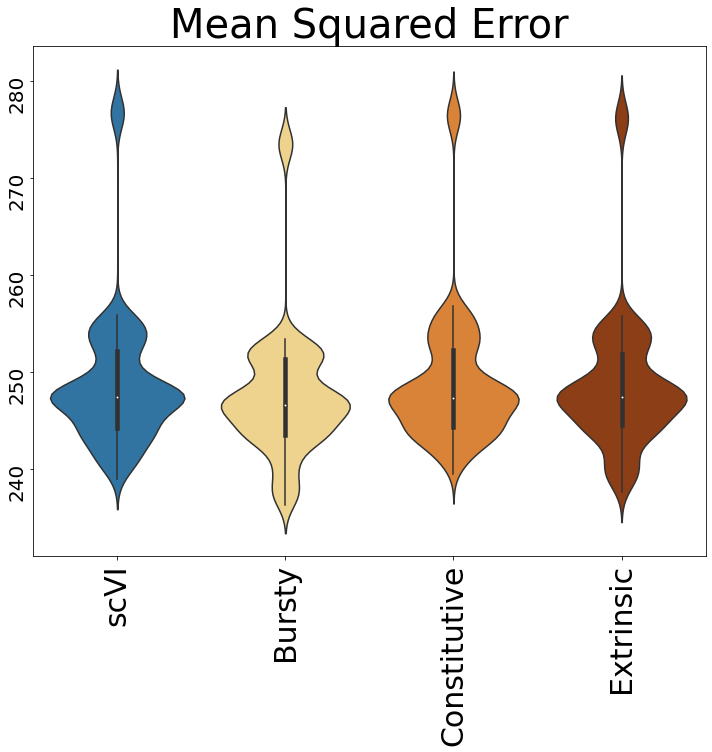

In [14]:
plot_metrics(metric_dict,['MSE'],fs = 20)
plt.title(f'Mean Squared Error',fontsize=40)
plt.savefig(f'../../results/{name}_figs/MSE_test.png',bbox_inches='tight')

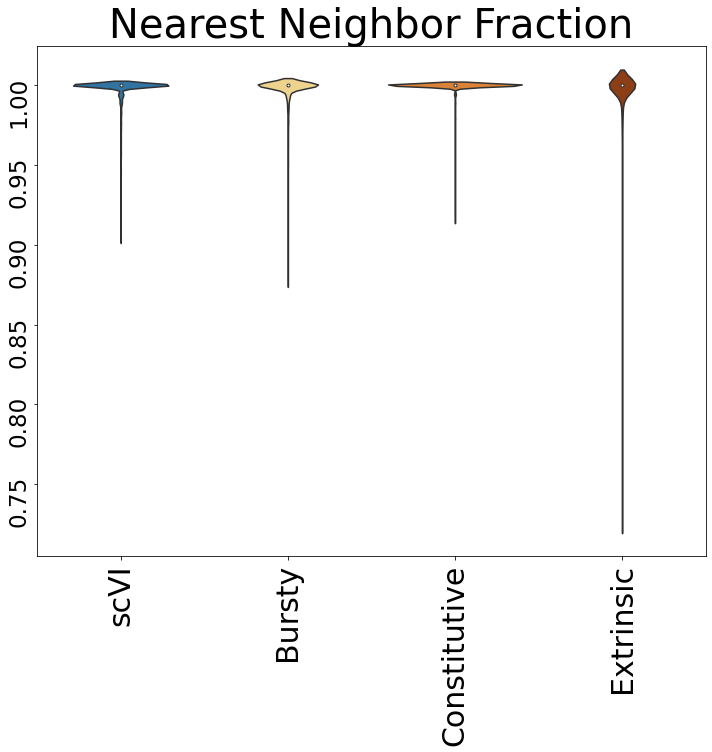

In [15]:
plot_metrics(metric_dict,['nearest_neighbors'],)
plt.title(f'Nearest Neighbor Fraction',fontsize=40)
plt.savefig(f'../../results/{name}_figs/nearest_neighbor_test.png',bbox_inches='tight')

-----------
# Test Reconstruction Error and Timing

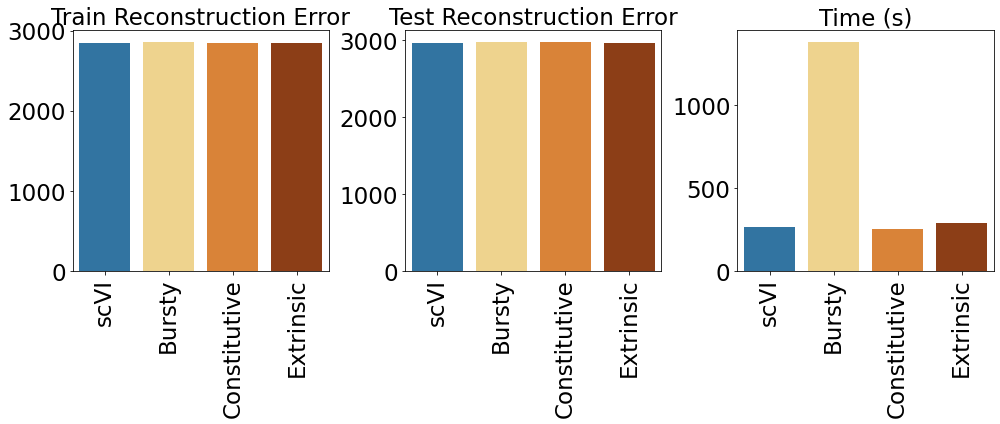

In [16]:
def plot_recon_loss(results_dict,kind):
  setups = list(results_dict.keys())

  df_plot = pd.concat([pd.DataFrame({'Train Reconstruction Error': -1*np.array(item[1]['recon_error'])[0,1]['reconstruction_loss'],
               
                'Test Reconstruction Error': -1*np.array(item[1]['recon_error'])[0,0]['reconstruction_loss'],
               
                'Time (s)': item[1]['runtime'][0],
                'Setup': item[0].split('-')[0],
                'latent space' : item[0].split('-')[1],
                'Constant' : item[0].split('-')[2]},index=[i]) for i,item in enumerate(results_dict.items())])



  fig,axes =plt.subplots(1,len(kind),figsize= (14,6))
  for i,k in enumerate(kind):
      ax = axes[i]
      _ = sns.barplot(data=df_plot, x='Setup', y=k, ax=ax,palette=color_list)
      #ax.get_legend().remove()
      ax.set_title(f'{k}',fontsize=fs)
      ax.set_ylabel(None)
      ax.set_xlabel(None)
      ax.tick_params(axis='y', which='both', labelsize=fs)
      ax.set_xticklabels(labels = ['scVI', 'Bursty', 'Constitutive', 'Extrinsic'], rotation = 90, fontsize = fs)

      #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
  plt.tight_layout()

  return(df_plot)


plot_recon_loss(results_dict,kind=['Train Reconstruction Error','Test Reconstruction Error','Time (s)']);
plt.savefig(f'../../results/{name}_figs/recon_error_time_{index}.png',bbox_inches='tight');






---------------

# KLD between Reconstructed and biVI Distributions

In [17]:
def plot_CDF(array1,array2,label1,label2,color2):

    cdf1 = np.zeros(len(array1))
    cdf2 = np.zeros(len(array2))
    array1_sorted = np.sort(array1)
    array2_sorted = np.sort(array2)
    for i,value in enumerate(array1_sorted):
        cdf1[i] = len(array1_sorted[array1_sorted<value])/len(array1_sorted)
    for i,value in enumerate(array2_sorted):
        cdf2[i] = len(array2_sorted[array2_sorted<value])/len(array2_sorted)

    
    plt.plot(array2_sorted,cdf2,label=label2,color=color2,linewidth=5)
    plt.plot(array1_sorted,cdf1,label=label1,linewidth=4,linestyle='--')
    plt.xlabel(f'KL Divergence',fontsize=20)
    plt.ylabel('Cumulative Fraction',fontsize=20)
    plt.title('Distribution Reconstruction Performance',fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend()
       


const_20ct_many mean, biVI 0.004396577
const_20ct_many mean, scVI 0.005127932


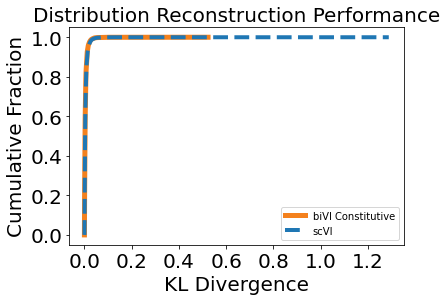

In [18]:
data_sets = ['const_20ct_many']
dnames = ['Constitutive']

for i,dset in enumerate(data_sets):
    
    with open(f'../../results/{dset}_figs/kld_dict.pickle', 'rb') as file:
        kld_dict = pickle.load(file)
        
        dname = dnames[i]
        
        print(f'{dset} mean, biVI',np.mean(kld_dict[f'{dname}-10-NAS_SHAPE']))
        print(f'{dset} mean, scVI',np.mean(kld_dict['scVI-10-NAS_SHAPE']))
        
        plot_CDF(kld_dict['scVI-10-NAS_SHAPE'],kld_dict[f'{dname}-10-NAS_SHAPE'],label1 = 'scVI',
        label2 = f'biVI {dname}',color2 = color_list[2])
        plt.savefig(f'../../results/{dset}_figs/KLD_CDF.png',bbox_inches='tight')
        plt.show()